In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from itertools import combinations
from sklearn.cluster import SpectralClustering

sns.set_theme()

def read_df(path):
    return pd.read_csv(path, sep="\t", compression="gzip", na_values="\\N")

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Movies dataset

In [3]:
# Load datasets
ratings = read_df("title.ratings.tsv.gz")
basics = read_df("title.basics.tsv.gz")
# Only keep movies
df = pd.merge(ratings, basics, on="tconst")
df_movies = df[df['titleType']=='movie']
df_movies.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
339,tt0000502,4.5,14,movie,Bohemios,Bohemios,0.0,1905.0,NaN,100.0,NaN
373,tt0000574,6.0,760,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,NaN,70.0,"Action,Adventure,Biography"
382,tt0000591,4.6,17,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,NaN,90.0,Drama
397,tt0000615,4.5,23,movie,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,NaN,NaN,Drama
405,tt0000630,3.8,24,movie,Hamlet,Amleto,0.0,1908.0,NaN,NaN,Drama


In [4]:
movies_df = df_movies[['tconst', 'averageRating', 'numVotes', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres']]
movies_df

,tconst,averageRating,numVotes,primaryTitle,startYear,runtimeMinutes,genres
339,tt0000502,4.5,14,Bohemios,1905.0,100.0,NaN
373,tt0000574,6.0,760,The Story of the Kelly Gang,1906.0,70.0,"Action,Adventure,Biography"
382,tt0000591,4.6,17,The Prodigal Son,1907.0,90.0,Drama
397,tt0000615,4.5,23,Robbery Under Arms,1907.0,NaN,Drama
405,tt0000630,3.8,24,Hamlet,1908.0,NaN,Drama
...,...,...,...,...,...,...,...
1240349,tt9916270,5.8,1331,Il talento del calabrone,2020.0,84,Thriller
1240353,tt9916362,6.4,4600,Coven,2020.0,92,"Drama,History"
1240357,tt9916428,3.6,15,The Secret of China,2019.0,NaN,"Adventure,History,War"
1240361,tt9916538,8.3,6,Kuambil Lagi Hatiku,2019.0,123,Drama


In [5]:
movies_df.to_csv("movie_dataset.csv", index=False)

In [6]:
print(f"There are %d movies in the dataset." % len(df_movies))

There are 277779 movies in the dataset.


In [7]:
# Separate the genres into categories
dummies = pd.get_dummies(df_movies['genres'])
genres = [c for c in dummies.columns if ',' not in c]
for col in genres:
    df_movies[col] = dummies[[c for c in dummies.columns if col in c]].sum(axis=1)
df_movies.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
339,tt0000502,4.5,14,movie,Bohemios,Bohemios,0.0,1905.0,NaN,100.0,...,0,0,0,0,0,0,0,0,0,0
373,tt0000574,6.0,760,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,NaN,70.0,...,0,0,0,0,0,0,0,0,0,0
382,tt0000591,4.6,17,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,NaN,90.0,...,0,0,0,0,0,0,0,0,0,0
397,tt0000615,4.5,23,movie,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
405,tt0000630,3.8,24,movie,Hamlet,Amleto,0.0,1908.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


Here we are interested in the average rating and number of votes of the movies and also their genres and year they came out.

In [8]:
df_movies.describe()

,averageRating,numVotes,isAdult,startYear,endYear,Action,Adult,Adventure,Animation,Biography,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
count,277779.000000,2.777790e+05,277779.000000,277750.000000,0.0,277779.000000,277779.000000,277779.000000,277779.000000,277779.000000,...,277779.000000,277779.000000,277779.000000,277779.000000,277779.000000,277779.000000,277779.000000,277779.000000,277779.000000,277779.000000
mean,6.126495,3.489011e+03,0.016643,1993.384313,NaN,0.103503,0.015721,0.062823,0.017172,0.030413,...,0.002358,0.000166,0.111038,0.023677,0.000083,0.011974,0.000040,0.081943,0.021391,0.018259
std,1.347046,3.382671e+04,0.127929,25.725281,NaN,0.304615,0.124395,0.242645,0.129912,0.171720,...,0.048502,0.012867,0.314180,0.152041,0.009099,0.108767,0.006293,0.274278,0.144684,0.133887
min,1.000000,5.000000e+00,0.000000,1896.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.300000,1.800000e+01,0.000000,1977.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.200000,5.700000e+01,0.000000,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,2.960000e+02,0.000000,2014.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,2.580201e+06,1.000000,2022.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df_movies["logNumVotes"] = np.log(df_movies["numVotes"])

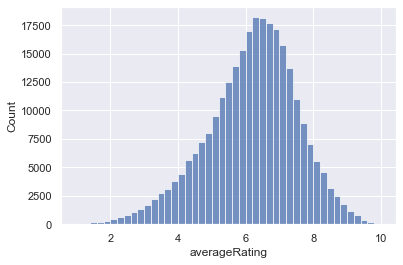

In [10]:
# How are the ratings distributed
sns.histplot(data=df_movies, x="averageRating", binwidth=0.20);

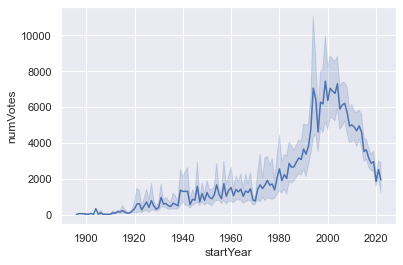

In [11]:
# Do newer movies receive more ratings ? 
sns.lineplot(data=df_movies, x="startYear", y="numVotes");

In [12]:
# What genres of movies receive more attention over time ?
# TODO: only keep n most relevant genres
df_movies["genres"].apply(lambda s: s.split(',') if isinstance(s, str) else None).explode()

339             None
373           Action
373        Adventure
373        Biography
382            Drama
             ...    
1240357    Adventure
1240357      History
1240357          War
1240361        Drama
1240372         None
Name: genres, Length: 476528, dtype: object

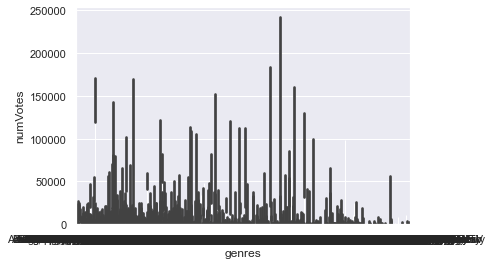

In [13]:
# What genres of movies receive more attention over time ?
# TODO: only keep n most relevant genres
sns.barplot(data=df_movies.explode("genres"), x="genres", y="numVotes");

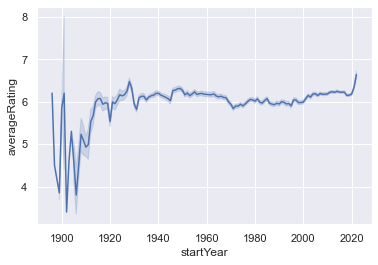

In [14]:
sns.lineplot(data=df_movies, x="startYear", y="averageRating");
# Important question: the increase of the average rating is due to real
# improvement of the movies or are we biased to give a better rating to
# what is more recent 

### Actors dataset

Here we are mostly interested in the actors, and eventually directors. The attribute "knownForTitle" will be used to link the actors together.

In [15]:
actors = pd.read_csv("name.basics.tsv.gz", sep="\t", compression="gzip", na_values = "\\N", nrows = 5000)
actors.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0050419,tt0053137,tt0072308"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0038355,tt0037382,tt0117057,tt0071877"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0049189,tt0056404,tt0054452,tt0057345"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0078723,tt0072562,tt0080455,tt0077975"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0060827,tt0050986,tt0083922,tt0069467"


In [16]:
actors_df = actors[['nconst', 'primaryName', 'knownForTitles']]
actors_df

,nconst,primaryName,knownForTitles
0,nm0000001,Fred Astaire,"tt0031983,tt0050419,tt0053137,tt0072308"
1,nm0000002,Lauren Bacall,"tt0038355,tt0037382,tt0117057,tt0071877"
2,nm0000003,Brigitte Bardot,"tt0049189,tt0056404,tt0054452,tt0057345"
3,nm0000004,John Belushi,"tt0078723,tt0072562,tt0080455,tt0077975"
4,nm0000005,Ingmar Bergman,"tt0060827,tt0050986,tt0083922,tt0069467"
...,...,...,...
4995,nm0005020,Josh Hopkins,"tt0177971,tt1441109,tt0119173,tt3829920"
4996,nm0005021,Kaitlin Hopkins,"tt1093908,tt0119822,tt0231402,tt0489237"
4997,nm0005022,Peter Horton,"tt0092492,tt7817340,tt0413573,tt3551796"
4998,nm0005023,Djimon Hounsou,"tt2015381,tt0450259,tt0298845,tt0118607"


In [17]:
actors_df.to_csv("actor_dataset.csv", index=False)

In [18]:
exploded_titles = actors.knownForTitles.apply(lambda s: s.split(',') if isinstance(s, str) else None).explode()

In [19]:
actors = actors.join(exploded_titles, rsuffix="_ex")

In [20]:
G_actors = nx.Graph()
G_actors.add_nodes_from(actors["primaryName"])

In [21]:
actors.groupby("knownForTitles_ex").primaryName.apply(lambda group: G_actors.add_edges_from(combinations(group, 2)));

Name: 
Type: Graph
Number of nodes: 4947
Number of edges: 22143
Average degree:   8.9521


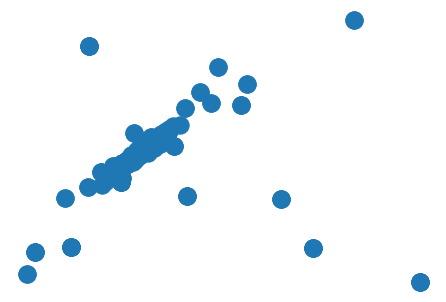

In [22]:
print(nx.info(G_actors))
nx.draw_spectral(G_actors)
# adj_mat = nx.to_numpy_matrix(G_actors)

# spectral_clustering = SpectralClustering(10, affinity="precomputed").fit(adj_mat)